In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import json 
from sklearn.metrics import confusion_matrix, classification_report,accuracy_score,roc_auc_score,plot_confusion_matrix,plot_roc_curve
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier, cv, plot_importance
from sklearn.linear_model import LogisticRegressionCV
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler

# Part 1 - EDA 

The attached logins.json file contains (simulated) timestamps of user logins in a particular geographic location. Aggregate these login counts based on 15­minute time intervals, and visualize and describe the resulting time series of login counts in ways that best characterize the underlying patterns of the demand. Please report/illustrate important features of the demand, such as daily cycles. If there are data quality issues, please report them.

In [2]:
pwd 

'/Users/andrewstephens/Springboard/ultimate_challenge'

In [3]:
login_data = pd.read_json('logins.json')
print(login_data.head(15))
print(login_data.info())

            login_time
0  1970-01-01 20:13:18
1  1970-01-01 20:16:10
2  1970-01-01 20:16:37
3  1970-01-01 20:16:36
4  1970-01-01 20:26:21
5  1970-01-01 20:21:41
6  1970-01-01 20:12:16
7  1970-01-01 20:35:47
8  1970-01-01 20:35:38
9  1970-01-01 20:47:52
10 1970-01-01 20:26:05
11 1970-01-01 20:31:03
12 1970-01-01 20:34:46
13 1970-01-01 20:36:34
14 1970-01-01 20:39:25
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 93142 entries, 0 to 93141
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   login_time  93142 non-null  datetime64[ns]
dtypes: datetime64[ns](1)
memory usage: 727.8 KB
None


In [4]:
# add a column to represent the number of logins during each time
login_data['login_count'] = 1
# convert the date to a datetime object, and set it as the index
login_data = login_data.set_index(pd.to_datetime(login_data['login_time'], unit='s'))[['login_count']]
# make sure everything worked
login_data.head()

,login_count
login_time,
1970-01-01 20:13:18,1
1970-01-01 20:16:10,1
1970-01-01 20:16:37,1
1970-01-01 20:16:36,1
1970-01-01 20:26:21,1


In [5]:
# resample the index, so that time is represented in 15min chunks
logins_delta15 = login_data.resample('15Min').sum()



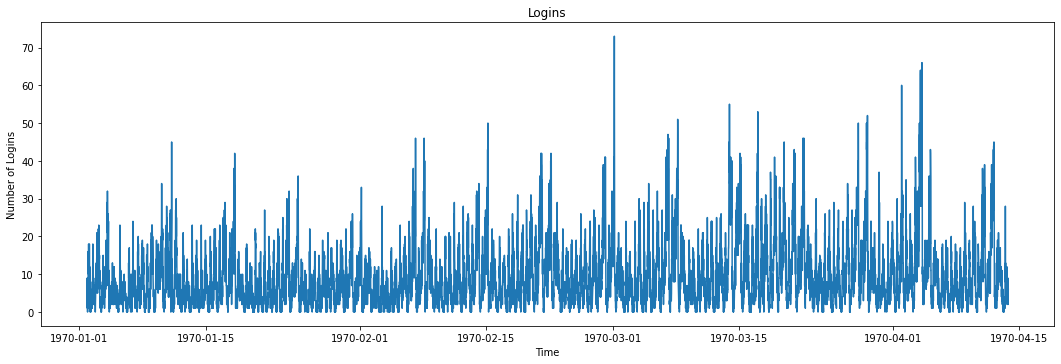

In [6]:
# scatterplot of the binned data
fig, ax = plt.subplots(figsize = (15,5))
plt.xlabel('Time')
plt.ylabel('Number of Logins')
plt.tight_layout()
plt.title('Logins')
# puts the data in the figure
plt.plot(logins_delta15.index, logins_delta15.login_count)



* Find hourly trends by day of week 

In [7]:
# resample index hourly
daily_logins = login_data.resample('H').sum()
# make a column that identify the day of week; Monday=0, Sunday=6
day_of_week = list(daily_logins.index.dayofweek)
daily_logins['day_of_week'] = day_of_week
# add column with just the hour (omiting the date)
daily_logins['hour'] = [time.hour for time in daily_logins.index]

In [8]:
# create dataframe of the average number of logins for each hour of each day
avg_hourly_logins = pd.pivot_table(daily_logins, values = 'login_count', index = 'hour', columns = 'day_of_week', aggfunc=np.mean).rename(columns= {0:'Monday',1:'Tuesday',2:'Wednesday',3:'Thursday',4:'Friday',5:'Saturday',6:'Sunday'})
# stack
avg_hourly_logins = avg_hourly_logins.stack(level=['day_of_week'])
# name the stack
avg_hourly_logins.name = 'avg_num_logins'
avg_hourly_logins_df = avg_hourly_logins.reset_index()

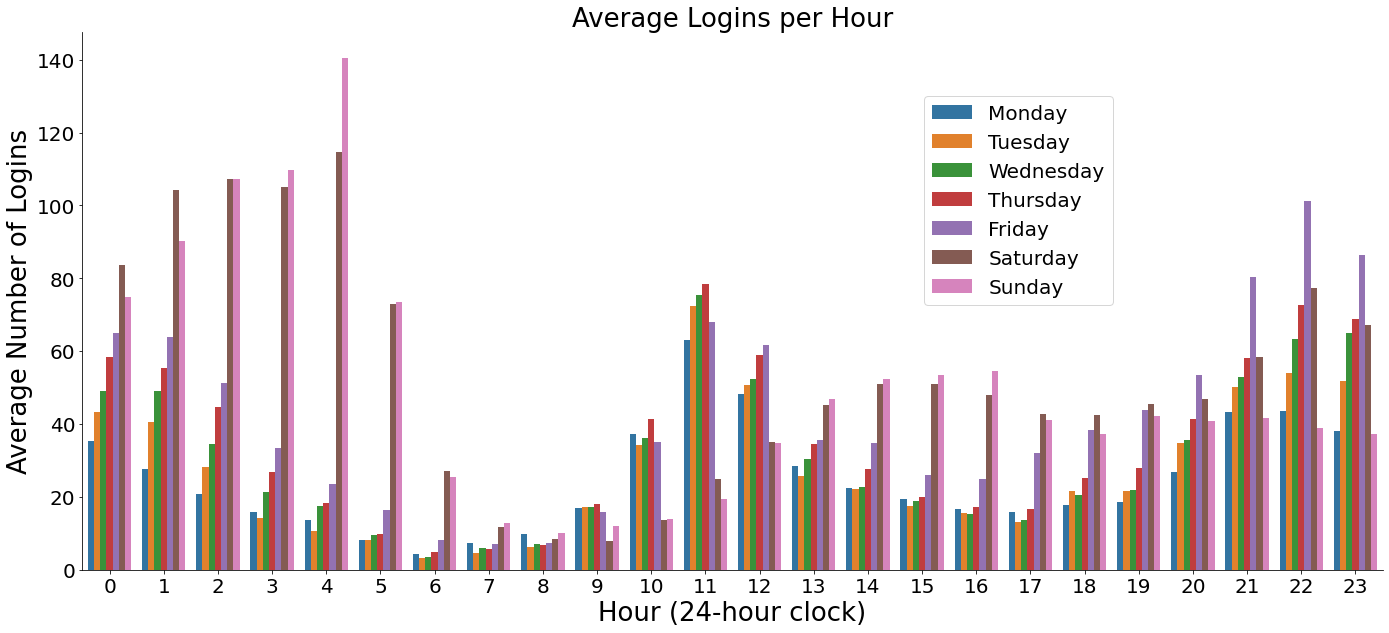

In [9]:


# plot average hourly use
sns.catplot(x='hour', y='avg_num_logins', data=avg_hourly_logins_df, kind = 'bar', 
            hue='day_of_week',height=8, aspect=11.7/5, legend=False)
ax = plt.gca()
ax.set_title('Average Logins per Hour', fontsize = 26)
ax.set_xlabel('Hour (24-hour clock)', fontsize = 26)
ax.set_ylabel('Average Number of Logins', fontsize = 26)
ax.tick_params(labelsize=20,labelcolor="black")
ax.legend(bbox_to_anchor=(0.7,0.7,0.1, 0.2),fontsize=20)



The bar graph shows the heaviest usage occurs during the early hours (1 AM - 5 AM) on Saturday and Sunday. During the weekdays there are smaller spikes in usage during lunch hours (11 am to noon), and in the evening (9 PM - 11 PM).


# Part 2 - Experiment and Metric design 

The neighboring cities of Gotham and Metropolis have complementary circadian rhythms: on weekdays, Ultimate Gotham is most active at night, and Ultimate Metropolis is most active during the day. On weekends, there is reasonable activity in both cities.
However, a toll bridge, with a two­way toll, between the two cities causes driver partners to tend to be exclusive to each city. The Ultimate managers of city operations for the two cities have proposed an experiment to encourage driver partners to be available in both cities, by reimbursing all toll costs.
1. What would you choose as the key measure of success of this experiment in encouraging driver partners to serve both cities, and why would you choose this metric?
2. Describe a practical experiment you would design to compare the effectiveness of the proposed change in relation to the key measure of success. Please provide details on:
a. how you will implement the experiment
b. what statistical test(s) you will conduct to verify the significance of the
observation
c. how you would interpret the results and provide recommendations to the city
operations team along with any caveats.


#1 To measure the success of the experiment I would use the change in weekday activity relative to demand. 

#2 
* A)Before implementation, we would want to know what the estimate of the percentage of drivers already using the toll bridge. We could use apps for the drivers phones to track that. 
* B) We would use a a hypothesis test comparing population proportions where the percentage of drivers who cross form the city with less demand to a city with greater demand. Null hypothesis would be the population proportion stays the same regardless of our proposed changes. 
* C) I would use a one tailed Z test to determine the p value of the hypothesis. If p-value < .05 reject null and recommend the reimbursement program continue, but still needs to be studied further. if P-value >.05 fail to reject null and recommend different program to increase partner driving between cities. 


# Part 3 ‐ Predictive modeling
Ultimate is interested in predicting rider retention. To help explore this question, we have provided a sample dataset of a cohort of users who signed up for an Ultimate account in
January 2014. The data was pulled several months later; we consider a user retained if they were “active” (i.e. took a trip) in the preceding 30 days.
We would like you to use this data set to help understand what factors are the best predictors for retention, and offer suggestions to operationalize those insights to help Ultimate.
The data is in the attached file ultimate_data_challenge.json. See below for a detailed description of the dataset. Please include any code you wrote for the analysis and delete the dataset when you have finished with the challenge.
1. Perform any cleaning, exploratory analysis, and/or visualizations to use the provided data for this analysis (a few sentences/plots describing your approach will suffice). What fraction of the observed users were retained?
2. Build a predictive model to help Ultimate determine whether or not a user will be active in their 6th month on the system. Discuss why you chose your approach, what alternatives you considered, and any concerns you have. How valid is your model? Include any key indicators of model performance.
3. Briefly discuss how Ultimate might leverage the insights gained from the model to improve its long­term rider retention (again, a few sentences will suffice).


In [10]:
# load data
with open('ultimate_data_challenge.json') as f:
    data = json.load(f)

# put data info pandas dataframe
user_data = pd.DataFrame(data)

# convert dates to datetime objects
user_data['signup_date'] = pd.to_datetime(user_data['signup_date'])
user_data['last_trip_date'] = pd.to_datetime(user_data['last_trip_date'])

# find the date the data was pulled
pull_date = user_data.last_trip_date.max()

# determine 30 days previous to the pull day
cut_off_day = pull_date - pd.Timedelta('30 days')

# add active status to dataframe 0= inactive, 1 = active
user_data['active_status'] = (user_data.last_trip_date > cut_off_day).astype('int')

# add dummies to categorical data
user_data = pd.get_dummies(user_data, columns = ['city', 'phone'])



In [11]:
# separate the active and inactive users
active_user = user_data[user_data.active_status == 1]
inactive_user = user_data[user_data.active_status == 0]



In [12]:
# fraction of the observed users that were retained
fraction = round((len(active_user.active_status)/len(user_data.active_status)) * 100, 2)
print('{} percent of users were retained.'.format(fraction))


36.62 percent of users were retained.


In [13]:
# calculate the mean and standard deviation for each feature
feature_columns = ['avg_dist', 'avg_rating_by_driver', 'avg_rating_of_driver', 'avg_surge',
 'surge_pct', 'ultimate_black_user', 'weekday_pct', 'city_Astapor',
 "city_King's Landing", 'city_Winterfell', 'phone_Android','phone_iPhone']
stats_dict = {}
for col in feature_columns:
    stats_dict[col] = [active_user[col].mean(), active_user[col].std(),
                       inactive_user[col].mean(),inactive_user[col].std()]



In [14]:
# create a dataframe of the statistics
stats_df = pd.DataFrame.from_dict(stats_dict, orient='index').rename(columns = {0:'active_mean', 1:'active_std', 2:'inactive_mean', 3:'inactive_std'})


Text(0.5, 1.0, 'Average of Features for Active and Inactive Users')

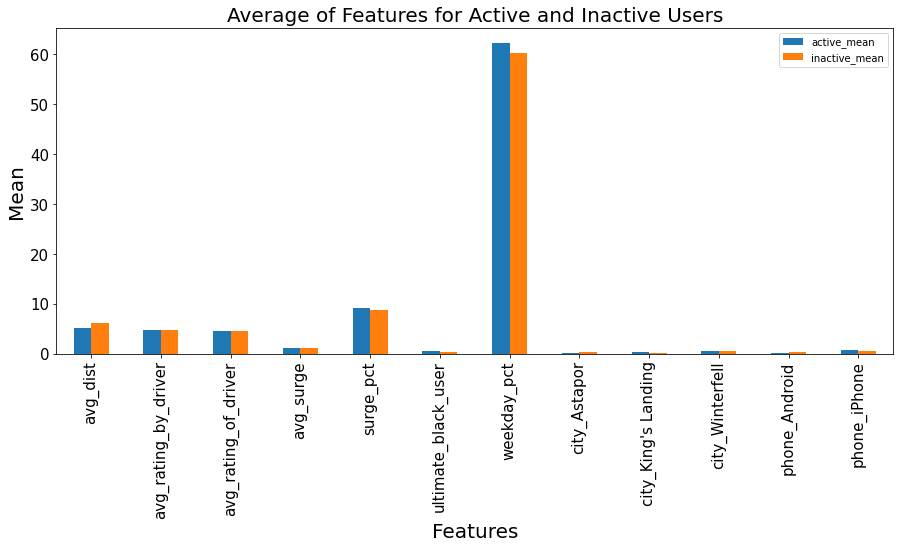

In [15]:
# visualize the statistics
stats_df[['active_mean', 'inactive_mean']].plot(kind = 'bar', yerr=stats_df[['active_std','inactive_std']], figsize = (15,6), fontsize = 15)
plt.xlabel('Features',fontsize = 20)
plt.ylabel('Mean', fontsize = 20)
plt.title('Average of Features for Active and Inactive Users', fontsize = 20)



The bar graph of the statistcs shows there is not a pronounce difference between the average of the features for active and inactive users. It also shows the weekday_pct feature has a much larger scale than the others, so the data may need to be normalized


This is a binary classification problem with both numerical and categorical data. We will use a simple model & robust model, such as Logistic Regression and XGBoost respectively. 

In [16]:
#user_data.replace([np.inf, -np.inf], np.nan, inplace=True)


In [17]:
# define features and target
X = user_data[feature_columns]
y = user_data.active_status
# split training and test data
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, random_state=1)



In [18]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 40000 entries, 18165 to 33003
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   avg_dist              40000 non-null  float64
 1   avg_rating_by_driver  39834 non-null  float64
 2   avg_rating_of_driver  33483 non-null  float64
 3   avg_surge             40000 non-null  float64
 4   surge_pct             40000 non-null  float64
 5   ultimate_black_user   40000 non-null  bool   
 6   weekday_pct           40000 non-null  float64
 7   city_Astapor          40000 non-null  uint8  
 8   city_King's Landing   40000 non-null  uint8  
 9   city_Winterfell       40000 non-null  uint8  
 10  phone_Android         40000 non-null  uint8  
 11  phone_iPhone          40000 non-null  uint8  
dtypes: bool(1), float64(6), uint8(5)
memory usage: 2.4 MB


In [19]:
# normalize data 
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform (X_test)



# Logistic Regression 

# Kept getting an error using logistic regression where( ValueError: Input contains NaN, infinity or a value too large for dtype('float64').)

* decided to move on 

# XGBoost 

In [21]:
# estimator
xb= XGBClassifier(random_state=1)

# grid searh to choose the best (combination of) hyperparameters
pg_xb={'n_estimators':[150,200], 'max_depth':[5,10,20],'min_child_weight':[.25,.5,.75]}

gs_xb=GridSearchCV(estimator= xb,
               param_grid= pg_xb,
               scoring='accuracy',
               cv=5)


In [22]:
# fit, and fit with best estimator
gs_xb.fit(X_train, y_train)
gs_xb_best=gs_xb.best_estimator_
gs_xb_best.fit(X_train, y_train)

print('Train Accuracy:   {0:.1f}%'.format(gs_xb.score(X_train, y_train)*100))
print('Test Accuracy:    {0:.1f}%'.format(gs_xb.score(X_test, y_test)*100))

Train Accuracy:   82.4%
Test Accuracy:    78.9%


In [23]:


# Print best parameters and results
print(gs_xb.best_params_)
print(gs_xb.best_score_)



{'max_depth': 5, 'min_child_weight': 0.75, 'n_estimators': 150}
0.78395


In [24]:
# using random forest results: confusion_matrix and classification report
ypreds=gs_xb_best.predict(X_test)
print(confusion_matrix(y_test,ypreds))
print(classification_report(y_test,ypreds))



[[5467  807]
 [1306 2420]]
              precision    recall  f1-score   support

           0       0.81      0.87      0.84      6274
           1       0.75      0.65      0.70      3726

    accuracy                           0.79     10000
   macro avg       0.78      0.76      0.77     10000
weighted avg       0.79      0.79      0.79     10000



Confusion matrix, without normalization
[[5467  807]
 [1306 2420]]
Normalized confusion matrix
[[0.87137392 0.12862608]
 [0.35050993 0.64949007]]


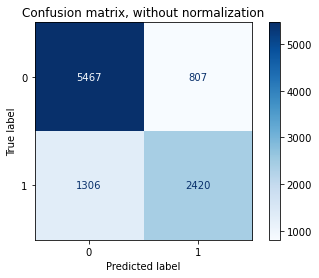

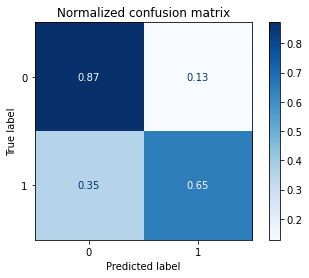

In [25]:
# Plot non-normalized confusion matrix
titles_options = [("Confusion matrix, without normalization", None),
                  ("Normalized confusion matrix", 'true')]
for title, normalize in titles_options:
    disp = plot_confusion_matrix(gs_xb, X_test, y_test,
                                 cmap=plt.cm.Blues,
                                 normalize=normalize)
    disp.ax_.set_title(title)

    print(title)
    print(disp.confusion_matrix)

plt.show()

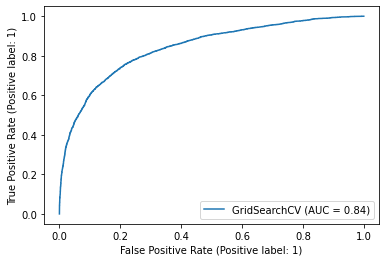

In [26]:

gb_roc = plot_roc_curve(gs_xb, X_test, y_test)



In [ ]:
#optimized hyper parameters 